In [22]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def great_circle_distance(lat1, lon1, lat2, lon2, radius=6371):
    """Returns the great-circle distance between two points on a sphere in km."""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    #Haversine Formula to compute the angular distance (a)
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) #central angle

    return radius * c

def generate_random_ocean_points(latitudes, longitudes, ocean_mask, cafein, cafeout, n_points, min_distance_km):
    """
    Generate random ocean points satisfying the distance condition and avoiding NaN values in NPP.
    
    Args:
        latitudes (np.array): Latitude array.
        longitudes (np.array): Longitude array.
        ocean_mask (np.array): Mask where ocean = True and land = False.
        cafein (xarray.Dataset): Input dataset (e.g., PAR, chl, mld, etc.).
        cafeout (xarray.Dataset): Output dataset (e.g., NPP).
        n_points (int): Number of random points to generate.
        min_distance_km (float): Minimum distance between points in kilometers.
    
    Returns:
        list: List of (x, y) indices for valid ocean points.
    """
    ocean_indices = np.argwhere(ocean_mask)  # Extract indices of ocean points
    selected_indices = []
    
    while len(selected_indices) < n_points:
        idx = tuple(ocean_indices[np.random.choice(ocean_indices.shape[0])])
        lat, lon = latitudes[idx[0]], longitudes[idx[1]]
        
        # Check distance from all previously selected points
        if all(great_circle_distance(lat, lon, latitudes[x[0]], longitudes[x[1]]) >= min_distance_km
            for x in selected_indices):
            # Check if any of the required values (like NPP) are NaN at this location
            if not np.isnan(cafein['sst'][:, idx[0], idx[1]].values).any():  # Ensure SST is not NaN
                selected_indices.append(idx)

    return selected_indices

In [3]:
files = sorted(glob("cafe_inputs/2023/cafe_in*.nc"))

# Extract the time (month) information from filenames and create datasets with time dimension
datasets = []
for file in files:
    # Extract time from filename (e.g., cafe_in_202301.nc -> 202301)
    month_str = file.split('_')[-1].split('.')[0]  # Adjust splitting for filename format
    time = pd.to_datetime(month_str, format="%Y%m")

    # Open the dataset and add a time dimension
    ds = xr.open_dataset(file)
    ds = ds.expand_dims(time=[time])  # Add time as a new dimension

    datasets.append(ds)

# Combine all datasets along the time dimension
cafein = xr.concat(datasets, dim="time")

In [4]:
files = sorted(glob("cafe_out/cafe_out*.nc"))

datasets = []
for file in files:
    month_str = file.split('_')[-1].split('.')[0]
    time = pd.to_datetime(month_str, format="%Y%m")

    ds = xr.open_dataset(file)
    ds = ds.expand_dims(time=[time])

    datasets.append(ds)

cafeout = xr.concat(datasets, dim="time")

In [5]:
# Define ocean mask from cafein['MLD']
ocean_mask = ~np.isnan(cafein['mld'][0, :, :].values)  # Valid ocean points without polar nights

# Process all cafein variables
for var in ['PAR', 'chl', 'aph_443', 'adg_443', 'bbp_443', 'bbp_s']:
    
    cafein[var] = cafein[var].where(ocean_mask, other=np.nan)  # Set land to NaN
    
    # Replace NaN with 0 in ocean regions
    cafein[var] = cafein[var].fillna(0)

# Process cafeout['npp']
cafeout['NPP'] = cafeout['NPP'].where(ocean_mask, other=np.nan)  # Set land to NaN
cafeout['NPP'] = cafeout['NPP'].fillna(0)  # NPP uses -9999.9 as replacement

lat = cafein['lat'].values 
lon = cafein['lon'].values

n_points = 500  # Number of locations
min_distance_km = 200  # Minimum distance in kilometers

random_indices = generate_random_ocean_points(lat, lon, ocean_mask, cafein, cafeout, n_points, min_distance_km)

In [10]:
# Extract data for the selected random indices
data = []

for t, time in enumerate(cafeout['time'].values):
    month_data = {
        "year": [],
        "yd": [],
        "lat": [],
        "lon": [],
        "PAR": [],
        "chl": [],
        "mld": [],
        "aph_443": [],
        "adg_443": [],
        "bbp_443": [],
        "bbp_s": [],
        "sst": [],
        "NPP": [],
    }
    
    for (rx, ry) in random_indices:
        # Extract data for the given location (rx, ry) and time step t
        datetime = pd.to_datetime(time)
#        month_data["year"].append(datetime.timetuple().tm_year) ask vitus
        month_data["yd"].append(datetime.timetuple().tm_yday)
        month_data["lat"].append(cafein['lat'][rx].values.item())
        month_data["lon"].append(cafein['lon'][ry].values.item())
        month_data["PAR"].append(cafein['PAR'][t, rx, ry].values.item())
        month_data["chl"].append(cafein['chl'][t, rx, ry].values.item())
        month_data["mld"].append(cafein['mld'][t, rx, ry].values.item())
        month_data["aph_443"].append(cafein['aph_443'][t, rx, ry].values.item())
        month_data["adg_443"].append(cafein['adg_443'][t, rx, ry].values.item())
        month_data["bbp_443"].append(cafein['bbp_443'][t, rx, ry].values.item())
        month_data["bbp_s"].append(cafein['bbp_s'][t, rx, ry].values.item())
        month_data["sst"].append(cafein['sst'][t, rx, ry].values.item())
        month_data["NPP"].append(cafeout['NPP'][t, rx, ry].values.item())
    
    data.append(pd.DataFrame(month_data))

# Combine all time steps into a single DataFrame
final_df = pd.concat(data, ignore_index=True)

# Save to CSV
csv_path = "random_cafe_2023.csv"
final_df.to_csv(csv_path, index=False)

In [11]:
final_df

,year,yd,lat,lon,PAR,chl,mld,aph_443,adg_443,bbp_443,bbp_s,sst,NPP
0,2023,1,15.791959,-34.799722,38.729286,0.107757,47.891811,0.006090,0.010400,0.001220,1.962650,24.377094,342.540100
1,2023,1,24.292117,-71.058115,32.237419,0.056273,49.354729,0.003923,0.006926,0.001399,1.984923,26.076933,233.033913
2,2023,1,-46.292524,86.478351,41.276257,0.193178,37.321510,0.017765,0.011936,0.002647,1.799835,9.243065,622.889166
3,2023,1,40.292413,-10.460755,16.893740,0.267602,75.419434,0.023971,0.015361,0.001157,1.747762,16.025160,367.306441
4,2023,1,-22.708754,-144.075017,51.549294,0.013007,26.648184,0.002714,0.002655,0.001849,1.997831,27.475042,283.189560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2023,335,14.708606,-54.637648,36.361675,0.068386,30.159847,0.005084,0.006545,0.001344,1.980480,28.230322,306.384853
5996,2023,335,-37.792367,-27.631396,47.006779,0.350540,28.738728,0.028316,0.014071,0.004273,1.608446,16.092096,840.263268
5997,2023,335,27.292172,139.907386,20.011868,0.158323,52.490005,0.012814,0.010271,0.001449,1.894686,24.213224,343.816642
5998,2023,335,-40.875757,124.570502,56.794903,0.080781,18.295267,0.011081,0.006745,0.003196,1.917321,14.737450,495.747478


In [12]:
for idx in random_indices:
    assert not np.isnan(cafein['sst'][11, idx[0], idx[1]].values), f"Invalid SST at {idx}"

In [13]:
for idx in random_indices:
    assert not np.isnan(cafeout['NPP'][1, idx[0], idx[1]].values), f"Invalid SST at {idx}"

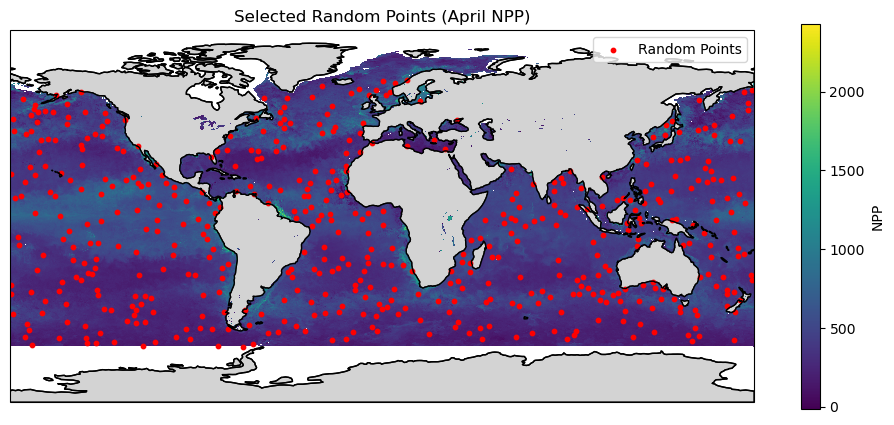

In [24]:
# Extract lat, lon, and NPP values
cafeout = xr.concat(datasets, dim="time")
lats = cafein['lat'].values
lons = cafein['lon'].values
npp = cafeout['NPP'][3, :, :].values

# Extract random points (lat, lon) for plotting
random_lat = [lats[idx[0]] for idx in random_indices]
random_lon = [lons[idx[1]] for idx in random_indices]

# Plot the map
plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add features to the map
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Plot NPP data
npp_plot = ax.pcolormesh(
    lons, lats, npp,
    transform=ccrs.PlateCarree(),
    cmap='viridis',  # Colormap for NPP
    shading='auto'
)
plt.colorbar(npp_plot, ax=ax, label='NPP')

# Overlay selected random points
ax.scatter(random_lon, random_lat, color='red', s=10, transform=ccrs.PlateCarree(), label='Random Points')

# Add legend and title
plt.legend(loc='upper right')
plt.title('Selected Random Points (April NPP)', fontsize=12)

# Show the plot
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

data = pd.read_csv("random_cafe_2023.csv")

In [7]:
# Define the inputs (X) and target (y)
# 'NPP' is the target variable and the rest are inputs
#X = data[["PAR", "chl", "mld", "lat", "lon", "aph_443", "adg_443", "bbp_443", "bbp_s", "sst", "yd"]]
X = data[["PAR", "chl", "mld", "aph_443", "adg_443", "bbp_443", "bbp_s", "sst"]]
y = data["NPP"]

# Split the data into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
rf.fit(X_train, y_train)
#r2 error for training too

RandomForestRegressor(random_state=42)

In [8]:
# Validate the model on the validation set
y_val_pred = rf.predict(X_val)
val_rmse = root_mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R^2: {val_r2:.4f}")

Validation RMSE: 39.3060
Validation R^2: 0.9608


In [9]:
# Test the model on the test set
y_test_pred = rf.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2: {test_r2:.4f}")

Test RMSE: 53.2904
Test R^2: 0.9447


In [10]:
# Feature importance analysis
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
   Feature  Importance
3  aph_443    0.559212
0      PAR    0.244144
5  bbp_443    0.064132
6    bbp_s    0.052263
4  adg_443    0.033051
2      mld    0.024484
7      sst    0.016530
1      chl    0.006184


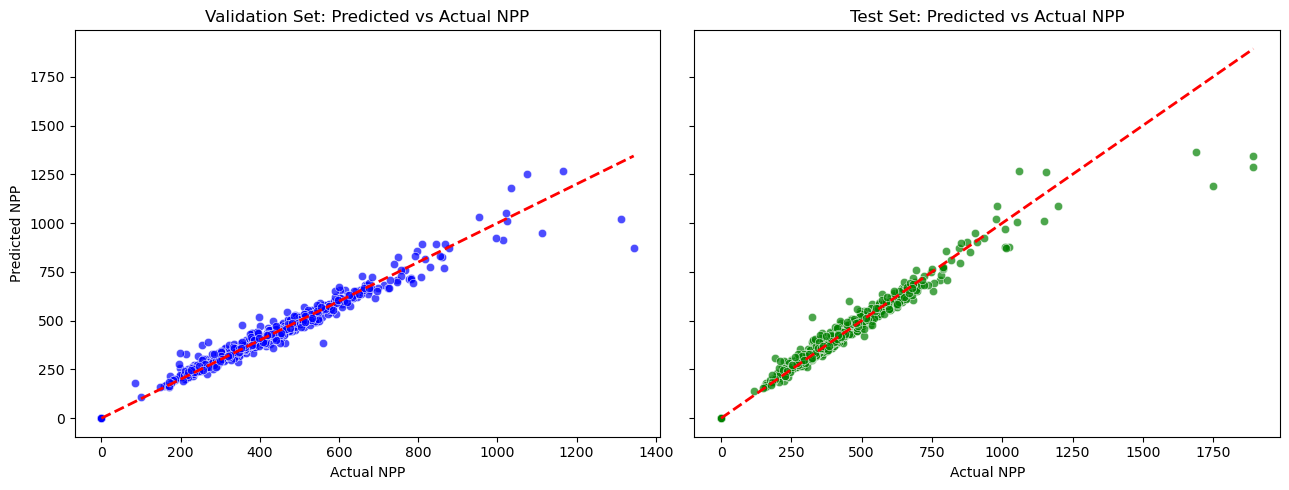

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

# Validation set scatter plot
sns.scatterplot(ax=axes[0], x=y_val, y=y_val_pred, alpha=0.7, color="blue")
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel("Actual NPP")
axes[0].set_ylabel("Predicted NPP")
axes[0].set_title("Validation Set: Predicted vs Actual NPP")

# Test set scatter plot
sns.scatterplot(ax=axes[1], x=y_test, y=y_test_pred, alpha=0.7, color="green")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel("Actual NPP")
axes[1].set_title("Test Set: Predicted vs Actual NPP")

plt.tight_layout()
plt.show()

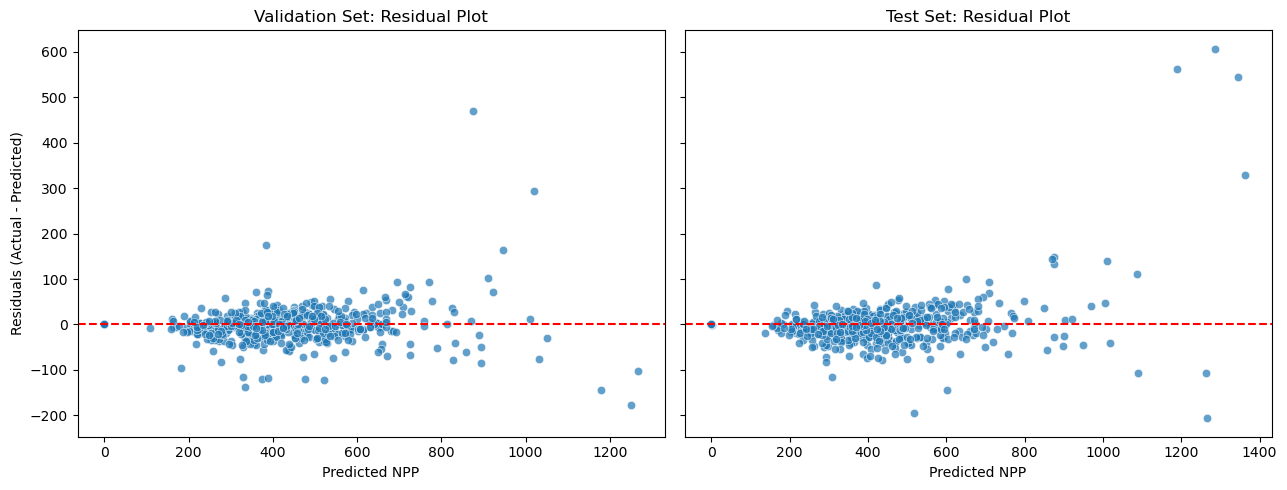

In [12]:
# Residuals for validation and test sets
val_residuals = y_val - y_val_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

sns.scatterplot(ax=axes[0], x=y_val_pred, y=val_residuals, alpha=0.7)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted NPP")
axes[0].set_ylabel("Residuals (Actual - Predicted)")
axes[0].set_title("Validation Set: Residual Plot")

sns.scatterplot(ax=axes[1], x=y_test_pred, y=test_residuals, alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted NPP")
axes[1].set_title("Test Set: Residual Plot")

plt.tight_layout()
plt.show()

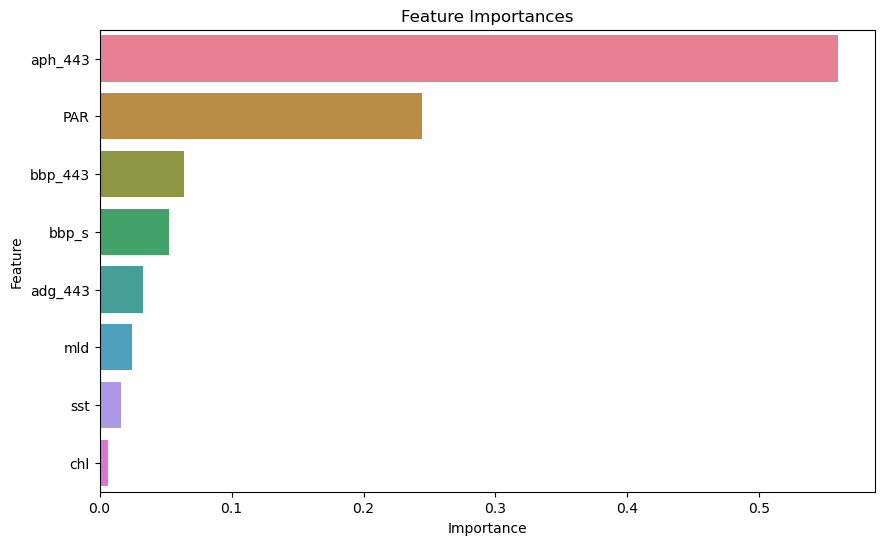

In [17]:
# Bar plot of feature importance
plt.figure(figsize=(10, 6))
#sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], hue=importance_df["Feature"],palette='husl')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#aph_443: Absorption due to phytoplankton at 443 nm, NASA GIOP algorithm [m^-1].
#PAR: Daily photosynthetic active radiation [mol photons m^-2 day^-1].
#bbp_443: Particulate backscatter at 443 nm, NASA GIOP model [m^-1].
#bbp_s: Backscattering spectral parameter for GIOP model [dimensionless].
#adg_443: Absorption due to gelbstoff and detrital material at 443 nm, NASA GIOP model [m^-1].
#mld: Mixed layer depth [m].
#sst: Sea surface temperature [degrees Celsius]. Only used to compute backscattering of pure seawater in function betasw_ZHH2009.
#lat: Latitude [degrees].
#chl: Chlorophyll concentration, NASA OCI algorithm [mg m^-3].
#lon: Longitude [degrees].
#yd: Day of the year.

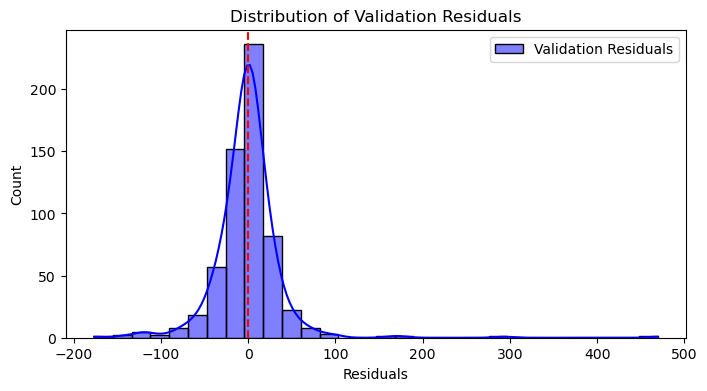

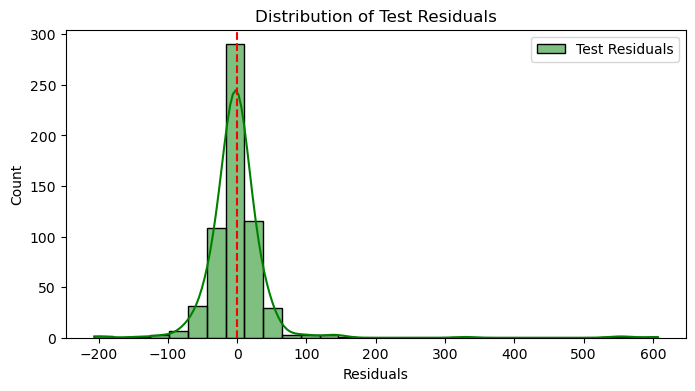

In [18]:
# Histogram of residuals (validation set)
plt.figure(figsize=(8, 4))
sns.histplot(val_residuals, kde=True, bins=30, color="blue", label="Validation Residuals")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.title("Distribution of Validation Residuals")
plt.legend()
plt.show()

# Histogram of residuals (test set)
plt.figure(figsize=(8, 4))
sns.histplot(test_residuals, kde=True, bins=30, color="green", label="Test Residuals")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.title("Distribution of Test Residuals")
plt.legend()
plt.show()

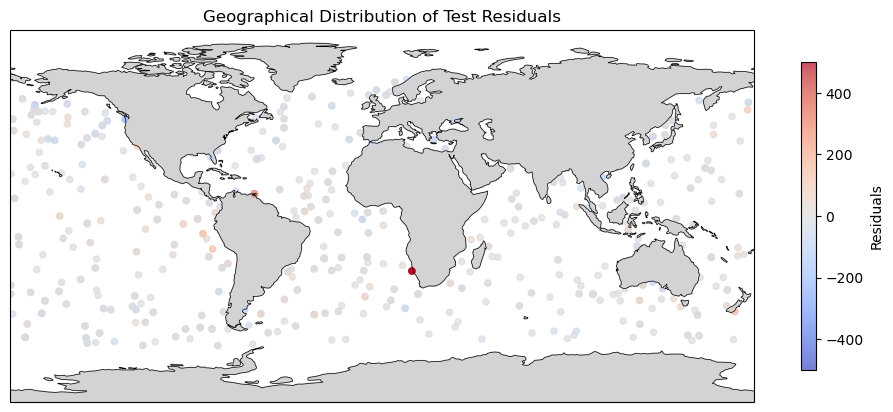

In [23]:
# Combine test results with lat/lon
test_results = pd.DataFrame({
    "lat": data["lat"],
    "lon": data["lon"],
    "residuals": test_residuals
})

plt.figure(figsize=(12, 5))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Global extent

ax.add_feature(cfeature.LAND, edgecolor='black', color='lightgray')  # Land
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Scatter plot of residuals
sc = plt.scatter(
    test_results["lon"],
    test_results["lat"],
    c=test_results["residuals"],
    cmap="coolwarm",
    s=20,
    alpha=0.7,
    transform=ccrs.PlateCarree(),vmin=-500,vmax=500)

plt.colorbar(sc, label="Residuals", orientation="vertical", shrink=0.8)

plt.title("Geographical Distribution of Test Residuals", fontsize=12)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

plt.show()

In [24]:
# Save the trained model
import joblib
joblib.dump(rf, "rf_CAFE_2023.pkl")
print("Model saved as RF CAFE 2023")

Model saved as RF CAFE 2023


In [31]:
# Load the trained model
rf = joblib.load("rf_CAFE_2023.pkl")

In [35]:
# Step 1: Create ocean mask based on MLD
ocean_mask = ~np.isnan(cafein['mld'][0, :, :].values)  # True for valid ocean, False for land

# Step 2: Handle missing satellite data
features_to_zero = ['PAR', 'chl', 'mld' ,'aph_443', 'adg_443', 'bbp_443', 'bbp_s']
inputs_list = []
for feature in features_to_zero:
    var = cafein[feature].values  # Extract the feature array
    var = np.where(ocean_mask, var, np.nan)  # Apply ocean mask
    var = np.nan_to_num(var, nan=0)  # Replace NaN with 0 only for ocean points
    inputs_list.append(var.ravel())  # Flatten and append

# Step 3: Handle SST (remove sea-ice coverage NaNs)
sst = cafein['sst'].values
sst = np.where(ocean_mask, sst, np.nan)  # Apply ocean mask for SST
inputs_list.append(sst.ravel())  # Flatten and append

# Stack the inputs into a single array
inputs = np.stack(inputs_list, axis=1)  # Shape: (n_points, n_features)

In [40]:
# Step 5: Remove rows where SST is NaN
valid_mask = ~np.isnan(inputs[:, 7])  # SST is the last column
inputs = inputs[valid_mask]

In [42]:
feature_names = ['PAR', 'chl', 'mld' ,'aph_443', 'adg_443', 'bbp_443', 'bbp_s','sst']

# Convert inputs array to a DataFrame
inputs_df = pd.DataFrame(inputs, columns=feature_names)
inputs_df

,PAR,chl,mld,aph_443,adg_443,bbp_443,bbp_s,sst
0,0.0,0.461636,12.084310,0.0,0.0,0.0,0.0,-1.300
1,0.0,0.468146,12.290571,0.0,0.0,0.0,0.0,-1.300
2,0.0,0.000000,13.603371,0.0,0.0,0.0,0.0,-1.055
3,0.0,0.000000,13.492972,0.0,0.0,0.0,0.0,-1.055
4,0.0,0.000000,13.464456,0.0,0.0,0.0,0.0,-1.055
...,...,...,...,...,...,...,...,...
63099065,0.0,0.000000,47.337608,0.0,0.0,0.0,0.0,7.385
63099066,0.0,0.000000,37.915062,0.0,0.0,0.0,0.0,6.730
63099067,0.0,0.000000,28.198978,0.0,0.0,0.0,0.0,6.725
63099068,0.0,0.000000,66.077408,0.0,0.0,0.0,0.0,6.175


In [43]:
# Predict NPP using the trained model
npp_predictions = rf.predict(inputs_df)  # Shape: (2160*4320,)
npp_predictions.shape

(63099070,)

In [45]:
# Reshape the predictions back to the spatial grid
npp_map = np.full(cafein['PAR'].shape, np.nan)  # Initialize with NaN
npp_map.ravel()[valid_mask] = npp_predictions

In [47]:
# Save the predicted NPP as a new dataset
npp_dataset = xr.Dataset(
    {
        "NPP": (["time", "lat", "lon"], npp_map)
    },
    coords={
        "time": cafein['time'].values,
        "lat": cafein['lat'].values,
        "lon": cafein['lon'].values,
    }
)

npp_dataset.to_netcdf("upscaled_NPP_2023.nc")

In [48]:
npp_dataset

<xarray.Dataset>
Dimensions:  (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2023-12-01
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Data variables:
    NPP      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

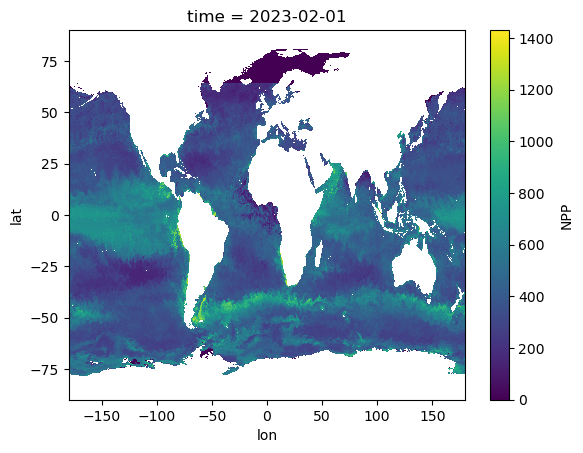

In [51]:
npp_dataset.isel(time=1).NPP.plot()

In [53]:
npp_dataset['time']

<xarray.DataArray 'time' (time: 12)>
array(['2023-01-01T00:00:00.000000000', '2023-02-01T00:00:00.000000000',
       '2023-03-01T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-05-01T00:00:00.000000000', '2023-06-01T00:00:00.000000000',
       '2023-07-01T00:00:00.000000000', '2023-08-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2023-12-01

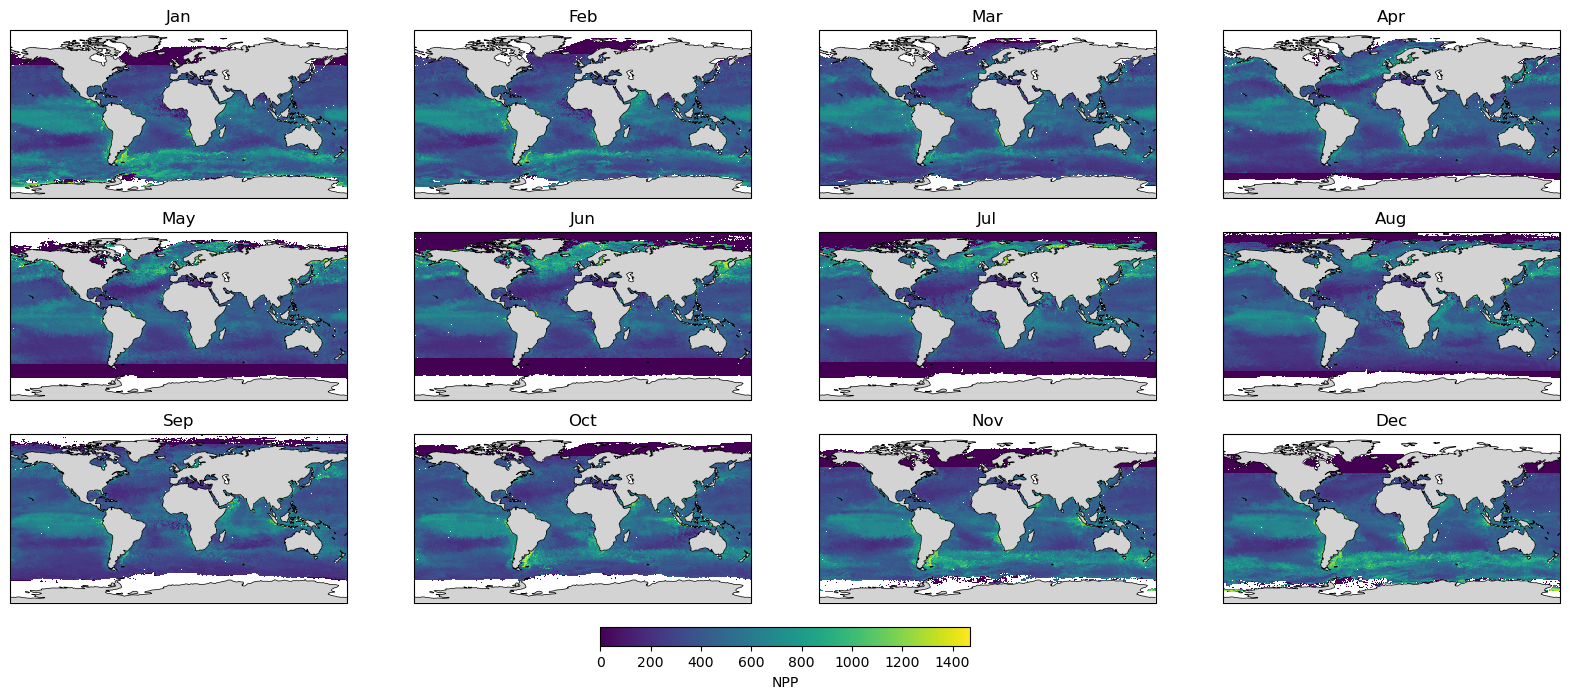

In [62]:
# Extract data and dimensions
npp_data = npp_dataset['NPP'].values  # Shape: (time, lat, lon)
lat = npp_dataset['lat'].values
lon = npp_dataset['lon'].values
months = pd.to_datetime(npp_dataset['time']).strftime('%b') # Convert time to month names

n_months = npp_data.shape[0]

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,8),
                         subplot_kw={'projection': ccrs.PlateCarree()})

for i, ax in enumerate(axes.flat):
    ax.set_extent([-180, 180, -90, 90])  # Global extent
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

    pcm = ax.pcolormesh(lon, lat, npp_data[i, :, :],
                        transform=ccrs.PlateCarree(), cmap='viridis')

    ax.set_title(months[i], fontsize=12)

cbar = fig.colorbar(pcm, ax=axes, orientation='horizontal', fraction=0.03, pad=0.04,
                    label="NPP")

plt.show()